### Arboles de decision
* se calcula la entropia (medida de desorden de un conjunto de datos) inicial del sistema basandose en la variable objetivo a predecir 
* se busca la homogeneidad de los datos
* calculamos la ganancia de informacion para cada variable candidata, seleccionando las que no de maxima ganancia de informacion como nodo de decision
* se repite este paso para cada rama de cada nodo (el nuevo nodo se llama nodo hoja)
* comprobamos si el nodo hoja clasifica bien (entropia nula, homogeneidad perfecta) , sino continuamos 
* el algoritmo para cuando la entropia es nula, o cuando nosotros se lo decimos, ya que podria ser infinito (max numero arboles o interaciones por ejemplo)
* otros algoritmo usan como referencia el indice gini, chi al cuadrado (chaid), o metodo reduccion de la varianza
* para evitar que el arbol tienda a infinito, y crea overfiting, que se comporta bien con el training pero mal con otros sets, hacemos poda del arbol (reduccion del error en la poda, poda del coste de complejidad)
* https://sitiobigdata.com/2019/12/14/arbol-de-decision-en-machine-learning-parte-1/
* https://sitiobigdata.com/2019/12/14/arboles-de-decision-en-machine-learning-parte-2/

### problemas habituales arboles
* en el caso de las variables continuas hay que encontrar umbrales optimos de corte (treshold) para convertilos en categoricas
* con valores nan : asignar el valor mas comun de la categoria donde falta la variable "teniendo en cuenta la variable de decision de la que faltan valores"; o sea, veo que columna falta un valor, compruebo su variable y, entonces de todas las variables y con esa caracteristica escogo la mas comun

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# usaremos el dataset de iris
url = r"C:\Users\gonza\OneDrive\Documentos\datascience-thebridge-master\ejercicios gonzalo\DATA\iris\Iris.csv"
data = pd.read_csv(url)
data.head(3)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa


In [3]:
data = data.drop("Id",axis=1)

(array([50.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0., 50.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

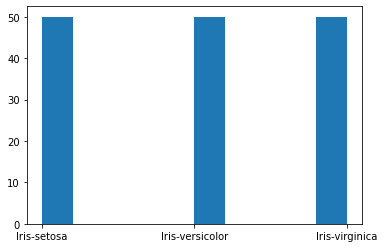

In [4]:
# vemos que estan compensadas
plt.hist(data.Species)

In [5]:
# separamos las columnas entre predictora y demas
colnames = data.columns.values.tolist()
predictors = colnames[:4]
target = colnames[4]

In [6]:
# hacemos de forma manual la seleccion train y test (se puede hacer con train split)
data["is_train"] = np.random.uniform(0,1,len(data))<=0.75

In [7]:
data["is_train"].value_counts()

True     111
False     39
Name: is_train, dtype: int64

In [8]:
train, test = data[data["is_train"]==True],data[data["is_train"]==False]

In [9]:
from sklearn.tree import DecisionTreeClassifier

In [10]:
trees = DecisionTreeClassifier(criterion="entropy",min_samples_split=20, random_state=99)
trees.fit(train[predictors],train[target])

DecisionTreeClassifier(criterion='entropy', min_samples_split=20,
                       random_state=99)

In [11]:
preds = trees.predict(test[predictors])

In [12]:
pd.crosstab(test[target],preds,rownames=["actual"],colnames=["prediction"])

prediction,Iris-setosa,Iris-versicolor,Iris-virginica
actual,,,
Iris-setosa,19,0,0
Iris-versicolor,0,6,0
Iris-virginica,0,2,12


In [13]:
# vemos que clasifica bien setos y versicolor, y ha tenido dos fallos con virginica

### visualizacion arbol decision

In [14]:
data.Species.unique().tolist()

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [15]:
predictors

['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

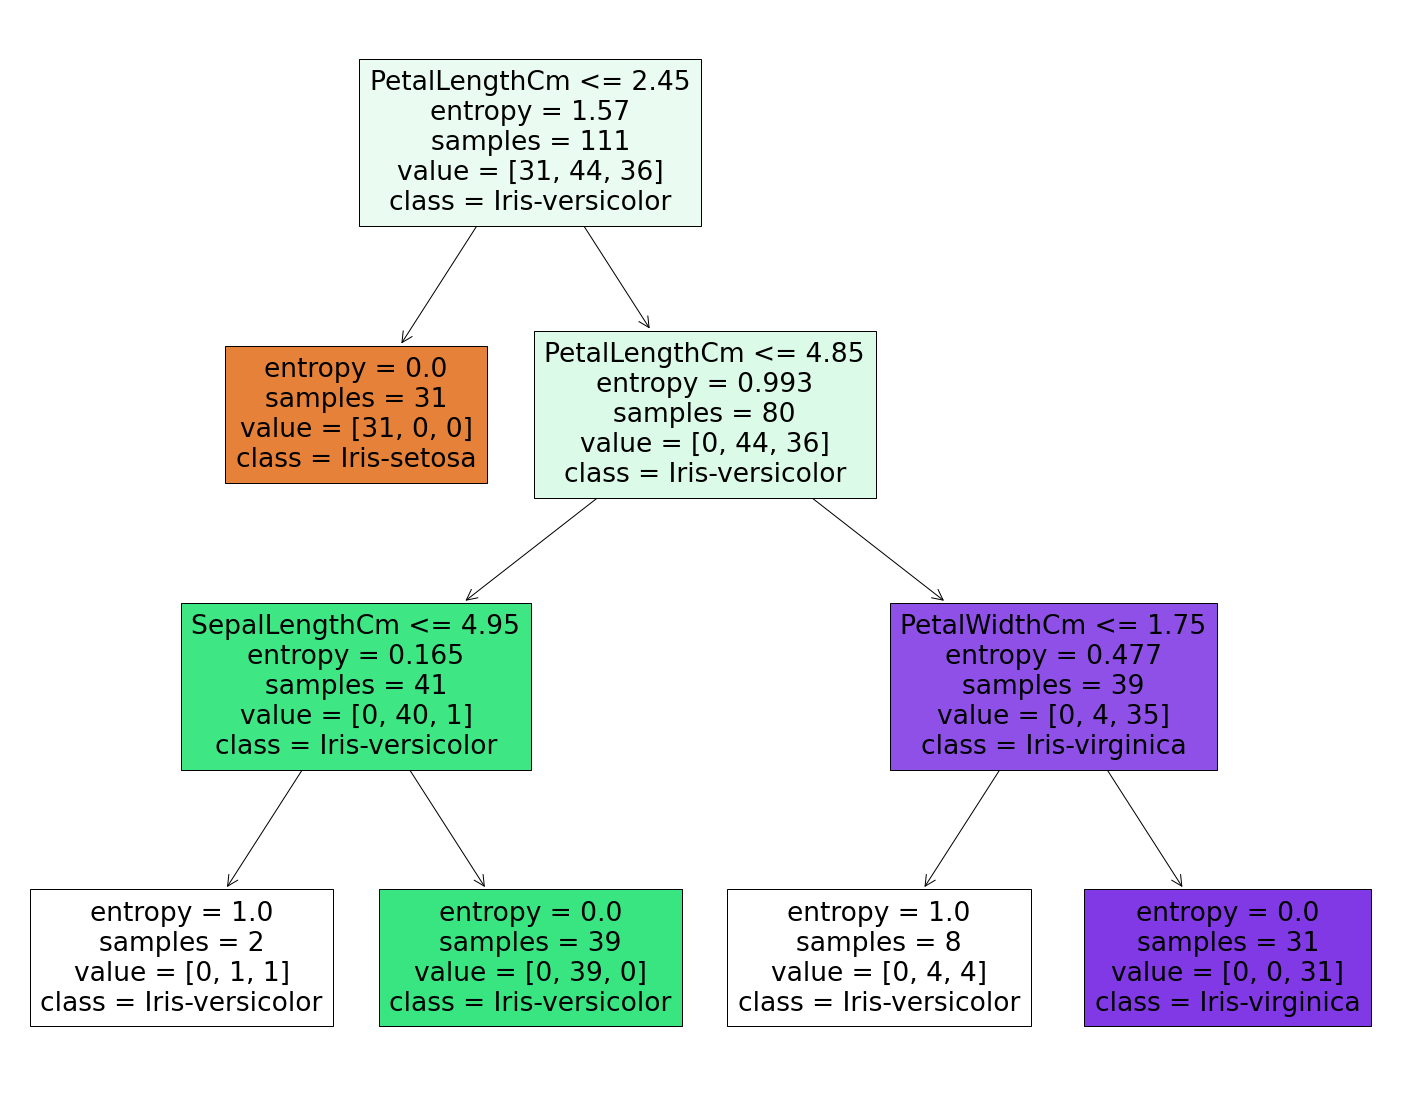

In [16]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(trees, 
                   feature_names=predictors,  
                   class_names=data.Species.unique().tolist(),
                   filled=True)

* lo primero es la condicion(ej cm<=), despues la entropia, cuando es 0 se para ya que tiene la informacion suciente, 
* hacia la izquierda son siempre true, donde se para, y por la derecha sigue expandiensose
* values son los valores que se van repartiendo hacia un lado u otro

In [17]:
# podemos ver tambien el accuracy
trees.score(test[predictors],test[target])

0.9487179487179487

### cross validation para el arbol (para podarlo :))
* para evitar overfiting o cualquier otro problema, vamos hacer cross validation para que el modelo generalize bien y no solo con el training set

In [19]:
X = data[predictors]
Y = data[target]

In [20]:
tree = DecisionTreeClassifier(criterion="entropy",max_depth=5,min_samples_split=20,random_state=99)
tree.fit(X,Y)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=20,
                       random_state=99)

In [25]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=10,shuffle=True,random_state=1)

In [28]:
from sklearn.model_selection import cross_val_score
score = np.mean(cross_val_score(tree,X,Y, scoring="accuracy",cv=cv,n_jobs=1))

In [29]:
score

0.9333333333333333

In [32]:
# podemos ir variando la profundida del arbol con max_depth
# podemos ver un test de importancia para ver que variables son las mas importartes
for i in range(1,11):
    tree = DecisionTreeClassifier(criterion="entropy",max_depth=i,min_samples_split=20)     
    tree.fit(X,Y)
    cv = KFold(n_splits=10,shuffle=True,random_state=1)
    score = np.mean(cross_val_score(tree,X,Y, scoring="accuracy",cv=cv,n_jobs=1))
    print(f"Score para n_splits={i} es {score}")
    print("  ", tree.feature_importances_)

Score para n_splits=1 es 0.5666666666666667
   [0. 0. 1. 0.]
Score para n_splits=2 es 0.9200000000000002
   [0. 0. 0. 1.]
Score para n_splits=3 es 0.9400000000000001
   [0.         0.         0.07060267 0.92939733]
Score para n_splits=4 es 0.9400000000000001
   [0.         0.         0.06844516 0.93155484]
Score para n_splits=5 es 0.9333333333333333
   [0.         0.         0.66869158 0.33130842]
Score para n_splits=6 es 0.9333333333333333
   [0.         0.         0.06844516 0.93155484]
Score para n_splits=7 es 0.9333333333333333
   [0.         0.         0.66869158 0.33130842]
Score para n_splits=8 es 0.9400000000000001
   [0.         0.         0.66869158 0.33130842]
Score para n_splits=9 es 0.9400000000000001
   [0.         0.         0.06844516 0.93155484]
Score para n_splits=10 es 0.9333333333333333
   [0.         0.         0.06844516 0.93155484]


Para crear el árbol utilizamos de la librería de sklearn tree.DecisionTreeClasifier pues buscamos un árbol de clasificación (no de Regresión). Lo configuramos con los parámetros:

* criterion=entropy (cuando categoricas) ó podría ser gini para numericas
* min_samples_split=20 se refiere a la cantidad mínima de muestras que debe tener un nodo para * poder subdividir.
* min_samples_leaf=5 cantidad mínima que puede tener una hoja final. Si tuviera menos, no se formaría esa hoja y “subiría” un nivel, su antecesor.
* class_weight= cuando estan desbalanzados los datos